## Initialization

In [1]:
import torch
from configs.config_loader import load_config
from model.neural_net import PhysicsInformedNN

# load default settings
config = load_config('configs/default.yaml', verbose=True)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:2" if use_cuda else "cpu")

# Initialize PINN instance
model = PhysicsInformedNN(config, device, verbose=True)
model = torch.compile(model)

version : default
seed : 0
L : 1
Re : 40
N_BC : 128
N_col : 1024
N_test : 128
n_hidden : 4
n_neurons : 50
activation : tanh
feature_scaling : True
n_epochs : 100000
learning_rate : 0.001
decay_rate : 0.9
alpha : 0.5
freq_log : 100
freq_print : 10000
keys_print : ['loss_train', 'loss_U', 'loss_F', 'loss_test']
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 2]                    --
├─Linear: 1-1                            [1, 50]                   150
├─Tanh: 1-2                              [1, 50]                   --
├─Linear: 1-3                            [1, 50]                   2,550
├─Tanh: 1-4                              [1, 50]                   --
├─Linear: 1-5                            [1, 50]                   2,550
├─Tanh: 1-6                              [1, 50]                   --
├─Linear: 1-7                            [1, 50]                   2,550
├─Tanh: 1-8                              [1,

## PINN training

In [2]:
model.train()

Training started...
     0/100000 | loss_train: 4.08e-01 | loss_U: 8.16e-01 | loss_F: 7.25e-04 | loss_test: 8.84e-01
 10000/100000 | loss_train: 2.29e-03 | loss_U: 3.41e-03 | loss_F: 1.16e-03 | loss_test: 9.71e-03
 20000/100000 | loss_train: 1.10e-03 | loss_U: 1.24e-03 | loss_F: 9.54e-04 | loss_test: 3.44e-03
 30000/100000 | loss_train: 1.91e-04 | loss_U: 1.64e-04 | loss_F: 2.18e-04 | loss_test: 5.30e-04
 40000/100000 | loss_train: 1.10e-04 | loss_U: 8.58e-05 | loss_F: 1.33e-04 | loss_test: 2.69e-04
 50000/100000 | loss_train: 8.50e-05 | loss_U: 6.49e-05 | loss_F: 1.05e-04 | loss_test: 1.63e-04
 60000/100000 | loss_train: 8.20e-05 | loss_U: 5.77e-05 | loss_F: 1.06e-04 | loss_test: 1.65e-04
 70000/100000 | loss_train: 7.53e-05 | loss_U: 5.46e-05 | loss_F: 9.60e-05 | loss_test: 1.69e-04
 80000/100000 | loss_train: 7.42e-05 | loss_U: 5.37e-05 | loss_F: 9.47e-05 | loss_test: 9.37e-05
 90000/100000 | loss_train: 7.57e-05 | loss_U: 5.33e-05 | loss_F: 9.81e-05 | loss_test: 1.33e-04
*** weight

OptimizedModule(
  (_orig_mod): PhysicsInformedNN(
    (neural_net): Sequential(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1): Tanh()
      (2): Linear(in_features=50, out_features=50, bias=True)
      (3): Tanh()
      (4): Linear(in_features=50, out_features=50, bias=True)
      (5): Tanh()
      (6): Linear(in_features=50, out_features=50, bias=True)
      (7): Tanh()
      (8): Linear(in_features=50, out_features=2, bias=True)
    )
  )
)

## Plotting

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.cm import get_cmap
plt.rcParams.update({'font.size': 8,
                     'axes.titlepad': 10,
                     'axes.titlesize': 10,
                     'axes.labelsize': 8,
                     'axes.linewidth': .5,
                     'xtick.major.width': .5,
                     'ytick.major.width': .5})

# load training log and data loader instance for plotting
log = model.callback.log
log_path = model.callback.model_path
data = model.data_loader

### Learning Curves and Apparent Pareto Front

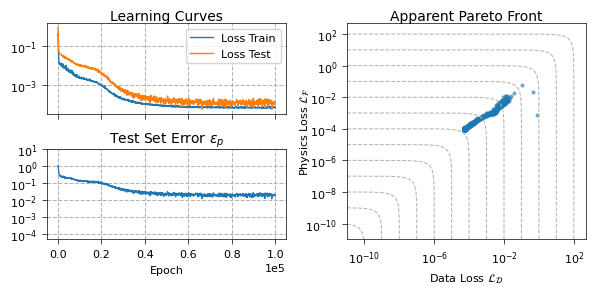

In [4]:
# select between 'u', 'v', and 'p'
plot_error = 'p'
######################
# Figure Preparation
######################
fig = plt.figure(figsize=(6, 3))
# Grid 
gs = GridSpec(nrows=2, ncols=2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[:, 1])

######################
# Plotting
######################
# Learning curves
lw = 1
epochs = np.arange(0, log['n_epochs'], log['freq_log'])
ax0.plot(epochs, log['loss_train'], label='Loss Train', lw=lw)
ax0.plot(epochs, log['loss_test'], label='Loss Test', lw=lw)
# Test Set Performance
ax1.plot(epochs, log[f'L2_test_{plot_error}'], lw=lw)
# Apparent Pareto Front
ax2.scatter(log['loss_U'], log['loss_F'], s=4, alpha=.5)

######################
# Plot Titles
######################
pad = -2
ax0.set_title('Learning Curves', pad=pad)
ax1.set_title(fr'Test Set Error $\epsilon_{plot_error}$', pad=pad)
ax2.set_title('Apparent Pareto Front', pad=pad)

######################
# Axis Appearance
######################
props_grid = {'zorder':1, 'alpha': 1, 'ls': '--', 'c': '0.7', 'lw': 0.75}

# Learning Curves Plot
ax0.set_yscale('log')
ax0.legend()
ax0.grid(**props_grid) 
ax0.set_xticklabels([])

# Test Set Performance Plot
lim = (5*1e-05, 1e+01)
ax1.set_yscale('log')
ax1.set_ylim(lim)
ax1.set_yticks([1e-04, 1e-03, 1e-02, 1e-01, 1e-00, 1e+01])
ax1.ticklabel_format(axis='x', style='sci', scilimits=(0,0), useOffset=True)
ax1.grid(**props_grid) 
ax1.set_xlabel('Epoch')

# Apparent Pareto Front Plot
lim = (1e-11, 5*1e+02)
xticks = [1e-10, 1e-06, 1e-02, 1e+02]
yticks = [1e-10, 1e-08, 1e-06, 1e-04, 1e-02, 1e-00, 1e+02]            
# grid lines
grid_lines_course = np.logspace(-11, 2, 14)
for grid_lines in grid_lines_course:
    x = np.linspace(1e-11, grid_lines, 600)
    ax2.plot(x, grid_lines-x, **props_grid)
ax2.set_xscale('log'), ax2.set_yscale('log') 
ax2.set_xlim(lim), ax2.set_ylim(lim)
ax2.set_xticks(xticks), ax2.set_yticks(yticks)
ax2.set_xlabel(r'Data Loss $\mathcal{L}_\mathcal{D}$')
ax2.set_ylabel(r'Physics Loss $\mathcal{L}_\mathcal{F}$', labelpad=-5)

plt.tight_layout()
plt.savefig(log_path.joinpath(f'learning_curves_{plot_error}.png'))
plt.show()

### Prediction Plot

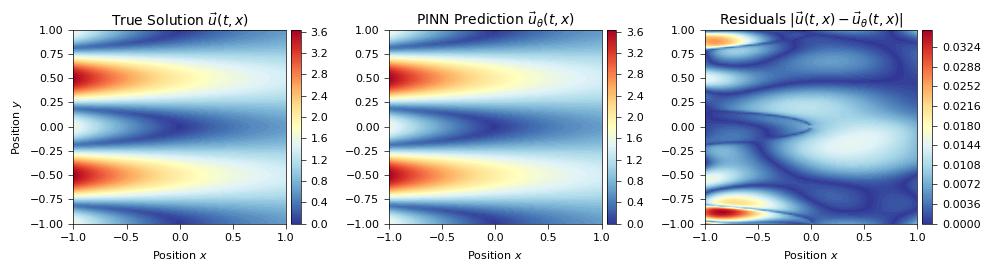

In [7]:
######################
# Figure Preparation
######################

fig, axes = plt.subplots(1, 3, figsize=(10, 2.75))

######################
# Data Preparation
######################
u_vec = lambda u: torch.sqrt(u[:,0]**2 + u[:,1]**2)

X, u_true = data.regular_grid(N=101)
u_pred = model(X)
u_res = torch.abs(u_vec(u_true) - u_vec(u_pred))
u_plot = [u_vec(u_true), u_vec(u_pred), u_res]

X = X.detach().cpu().numpy()
for i in range(len(u_plot)):
    u_plot[i] = u_plot[i].detach().cpu().numpy()
    
######################
# Plotting
######################
props = {'cmap': 'RdYlBu_r', 'levels': 100}
for (ax, u) in zip(axes, u_plot):
    tri = ax.tricontourf(X[:,0], X[:,1], u, **props)
    fig.colorbar(tri, ax=ax, pad=0.02)

######################
# Plot Titles
######################
pad = -2
axes[0].set_title(r'True Solution $\vec u(t,x)$', pad=pad)
axes[1].set_title(r'PINN Prediction $\vec u_\theta(t,x)$', pad=pad)
axes[2].set_title(r'Residuals $|\vec u(t,x)-\vec u_\theta(t,x)|$', pad=pad)

######################
# Axis Appearance
######################
axes[0].set_ylabel('Position $y$')
for ax in axes:
    ax.set_xlabel('Position $x$')

plt.tight_layout()
plt.savefig(log_path.joinpath('prediction.png'))
plt.show()